In [17]:
pip install nonconformist

Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_boston
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from nonconformist.icp import IcpClassifier, IcpRegressor
from nonconformist.nc import ClassifierNc, MarginErrFunc, ClassifierAdapter, RegressorNc, AbsErrorErrFunc
from sklearn.model_selection import train_test_split

In [19]:
def regression_calibration_curve(estimator, X, y, alphas=np.linspace(0.1,1,10, endpoint=True)):
    errors = []
    interval_sizes = []
    for a in alphas:
        pred = estimator.predict(X, significance=a)
        interval_sizes.append(np.mean([y-x for x, y in pred]))
        errors.append( 1 - np.mean([x <= z and z <= y for (x,y), z in zip(pred, y)]))
    return errors, interval_sizes

In [27]:
def regression_calibration_plot(estimator, X, y, alphas=np.linspace(0.1,1,10, endpoint=True)):
    errors, interval_sizes = regression_calibration_curve(estimator,X,y,alphas)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot([0,1], [0,1])
    ax1.plot(alphas, errors, 'o')
    ax2.plot(alphas, interval_sizes, '-')
    ax1.set_xlabel('Significance')
    ax1.set_ylabel('Error Rate')
    ax2.set_ylabel('Avg. Interval Size')
    plt.title('Regression Conformal Calibration Curve')
    plt.show()

In [28]:
def classifier_calibration_curve(estimator, X, y, alphas =np.linspace(0,1,10, endpoint=True)):
    errors = []
    set_sizes = []
    for a in alphas:
        pred = estimator.predict(X, significance=a)
        set_sizes.append(np.mean([np.sum(set) for set in pred]))
        errors.append(1 - np.mean([set[t] for set, t in zip(pred, y)]))
    return errors, set_sizes

In [32]:
def classification_calibration_plot(estimator, X, y, alphas=np.linspace(0,1,10, endpoint=True)):
    errors, sizes = classifier_calibration_curve(estimator,X,y,alphas)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot([0,1], [0,1])
    ax1.plot(alphas, errors, 'o')
    ax2.plot(alphas, sizes, '-')
    ax1.set_xlabel('Significance')
    ax1.set_ylabel('Error Rate')
    ax2.set_ylabel('Avg. Set Size')
    plt.title('Classification Conformal Calibration Curve')
    plt.show()

In [33]:
data = load_boston()
y = data.target
X = data.data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_calibration, X_test, y_calibration, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=42)

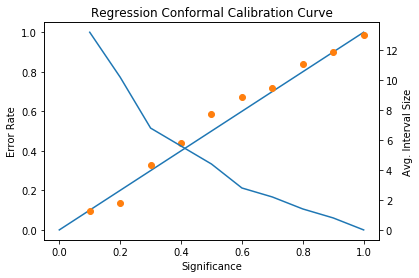

In [34]:
estimator = DecisionTreeRegressor(random_state=10)
icp = IcpRegressor( RegressorNc(estimator, AbsErrorErrFunc()))
icp.fit(X_train, y_train)
icp.calibrate(X_calibration, y_calibration)
regression_calibration_plot(icp, X_test, y_test)

In [35]:
data = load_iris()
y = data.target
X = data.data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)
X_calibration, X_test, y_calibration, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=2)

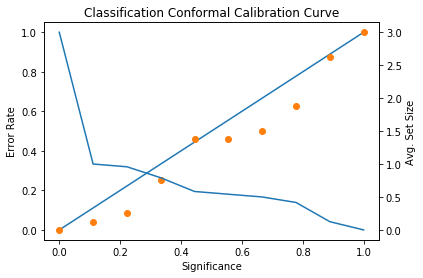

In [36]:
estimator = DecisionTreeClassifier(random_state=10)
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(estimator), MarginErrFunc()))
icp.fit(X_train, y_train)
icp.calibrate(X_calibration, y_calibration)
prediction = icp.predict(X_test, 0.1)
classification_calibration_plot(icp, X_test, y_test)